In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Excercise 7: Train and fine-tune a decision tree for the moons dataset

In [2]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10_000, noise=0.4, random_state=43)

Text(0, 0.5, '$X1$')

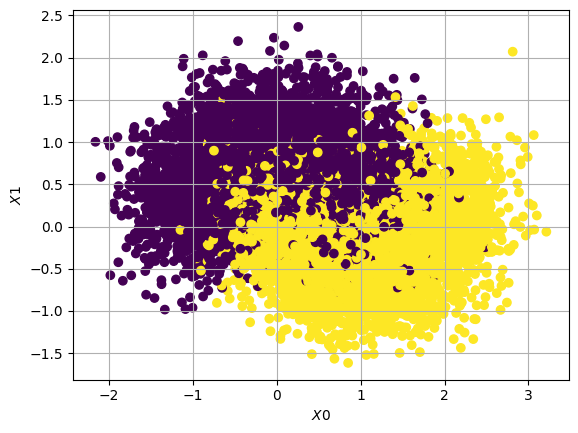

In [3]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.grid()
plt.xlabel("$X0$")
plt.ylabel("$X1$")

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=43)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'max_depth': [None, 2, 3, 5, 10],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 5],
        'max_features': [None, 1],
        'max_leaf_nodes': [None, 3, 5, 10]
    }
]
tree_clf = DecisionTreeClassifier(random_state=43)
grid_search = GridSearchCV(tree_clf, param_grid, cv=3,
                           n_jobs=8, scoring="accuracy")
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=43), n_jobs=8,
             param_grid=[{'max_depth': [None, 2, 3, 5, 10],
                          'max_features': [None, 1],
                          'max_leaf_nodes': [None, 3, 5, 10],
                          'min_samples_leaf': [1, 2, 5],
                          'min_samples_split': [2, 3, 5]}],
             scoring='accuracy')

In [6]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8522666666666666
{'max_depth': 5, 'max_features': 1, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [7]:
best_tree = grid_search.best_estimator_

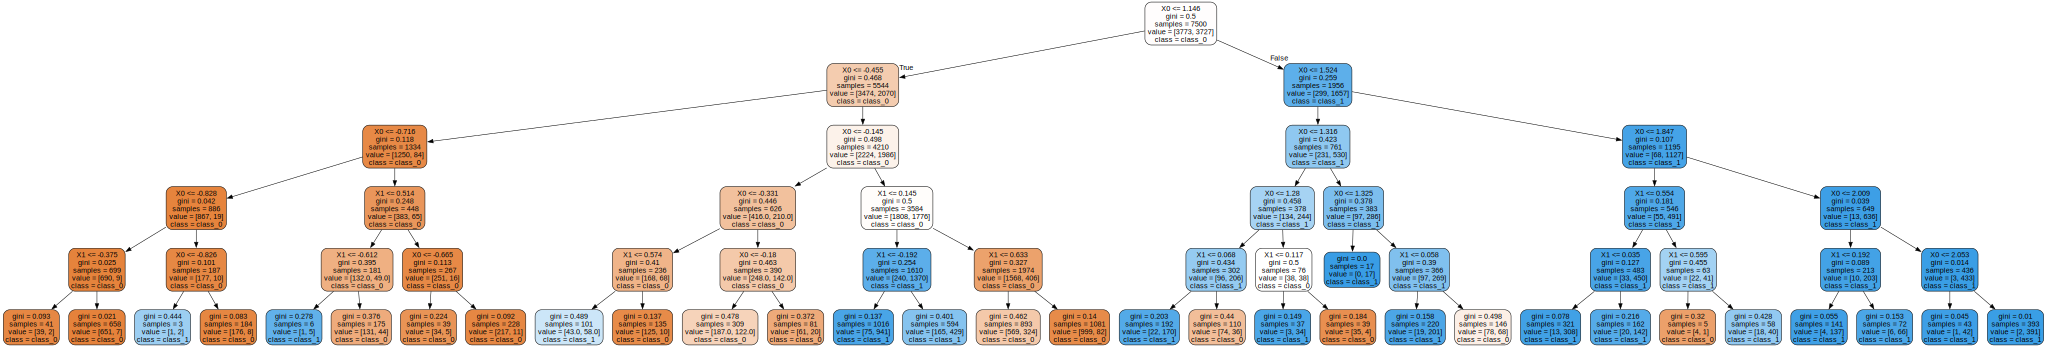

In [8]:
# Visualize the tree
from sklearn.tree import export_graphviz

export_graphviz(
    best_tree,
    out_file="exc_6_7_best_tree.dot",
    feature_names=["X0", "X1"],
    class_names=["class_0", "class_1"],
    rounded=True,
    filled=True
)

# Display the graphviz file
from graphviz import Source

Source.from_file("exc_6_7_best_tree.dot")

In [9]:
best_tree.score(X_test, y_test)

0.8332

Accuracy on the test set: 83.3%

### Excercise 8
Grow a forest by following these steps:

1. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s ShuffleSplit class for this.

2. Train one decision tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.

3. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.

4. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a random forest classifier!

In [10]:
# Split the training set into 1000 subsets of 100 size each
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1000, train_size=100, random_state=43)

In [11]:
# Train 1000 trees, one on each split
trees = []
scores = []
best_params = best_tree.get_params()
for i, (train_index, test_index) in enumerate(splitter.split(X_train)):
    tree = DecisionTreeClassifier()
    tree.set_params(**best_params)
    tree.fit(X_train[train_index], y_train[train_index])
    trees.append(tree)
    scores.append(tree.score(X_test, y_test))
    if (i % 100 == 0):
        print(f"Fold {i} accuracy: {scores[i]}")

Fold 0 accuracy: 0.8232
Fold 100 accuracy: 0.794
Fold 200 accuracy: 0.8352
Fold 300 accuracy: 0.746
Fold 400 accuracy: 0.8024
Fold 500 accuracy: 0.7836
Fold 600 accuracy: 0.7952
Fold 700 accuracy: 0.7744
Fold 800 accuracy: 0.7536
Fold 900 accuracy: 0.802


In [12]:
np.mean(scores)

0.7871228

In [13]:
# # Generate the predictions of all the trees for each sample of the test set
# # and keep the most frequent prediction for every sample
# from scipy.stats import mode

# most_frequent_predictions = []
# for i in range(y_test.size):
#     sample_predictions = []
#     for tree in trees:
#         pred = tree.predict([X_test[i]])
#         sample_predictions.append(pred[0]) # use [0] to get the value without dimensions
#     most_frequent = mode(sample_predictions).mode
#     most_frequent_predictions.append(most_frequent)


# # Evaluate the most frequent predictions 
# from sklearn.metrics import accuracy_score

# accuracy_score(y_test, most_frequent_predictions)

In [14]:
# Out of curiosity, let's try to improve the double for loop above according to the book solution
from sklearn.metrics import accuracy_score
from scipy.stats import mode

n_trees = 1000
# Each column holds the predictions of all the trees for the corresponding test sample.
# Each row is the predictions of the corresponding tree for the whole test set.
Y_pred = np.empty((n_trees, len(X_test)), dtype=np.uint8)
for tree_index, tree in enumerate(trees):
    Y_pred[tree_index] = tree.predict(X_test)

y_pred_majorty_votes, n_votes = mode(Y_pred, axis=0)
accuracy_score(y_test, y_pred_majorty_votes.reshape([-1]))

0.8596

Accuracy got improved relative to the single tree score, but I had to try various random states until I found one that got the forest to win (random_state=43).
Also, the version of the book's solution for calculating the forest predictions is infinitely faster than my version with the double for loop!